In [3]:
#pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.4 MB/s 


# Importing and preprocessing data


We are interested in predicting Domestic Auto sales using the values of everything else on the Time Series. Since this is time series data, we will implement LSTM neural networks for this purpose.

Importing the data

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pymssql
from lstm_config import *

In [4]:
database = database
table = table
user = user
password  = password
server = server

In [312]:
import pymssql
conn = pymssql.connect(server=server, user=f'{user}@{server}', password=password, database=database)

In [313]:
df = pd.read_sql('SELECT * FROM TimeSeries',conn)
df

,date,Domestic Autos,Domestic Light Trucks,Foreign Autos,Foreign Light Trucks,Heavy Trucks,Gas Price
0,1967-01-01,7.837,1.235,0.629,None,0.359,None
1,1967-02-01,6.85,1.138,0.69,None,0.304,None
2,1967-03-01,7.22,1.237,0.74,None,0.359,None
3,1967-04-01,8.164,1.204,0.746,None,0.343,None
4,1967-05-01,7.961,1.184,0.782,None,0.344,None
...,...,...,...,...,...,...,...
664,2022-05-01,1.937,8.277,0.749,1.803,0.491,4.272
665,2022-06-01,2.039,8.322,0.666,1.989,0.475,4.764
666,2022-07-01,2.046,8.671,0.746,1.868,0.468,4.413
667,2022-08-01,1.994,8.305,0.854,2.028,0.441,3.822


In [314]:
df.drop(columns = 'date', inplace = True)
df.dropna(inplace = True)
df = df.astype(float)
df

,Domestic Autos,Domestic Light Trucks,Foreign Autos,Foreign Light Trucks,Heavy Trucks,Gas Price
283,6.877,3.804,2.315,0.586,0.277,1.218
284,7.408,3.841,2.251,0.525,0.273,1.258
285,6.928,3.740,2.227,0.588,0.266,1.335
286,6.367,3.693,2.234,0.583,0.257,1.324
287,6.547,3.466,2.134,0.555,0.256,1.341
...,...,...,...,...,...,...
663,2.234,9.364,0.781,2.135,0.442,3.960
664,1.937,8.277,0.749,1.803,0.491,4.272
665,2.039,8.322,0.666,1.989,0.475,4.764
666,2.046,8.671,0.746,1.868,0.468,4.413


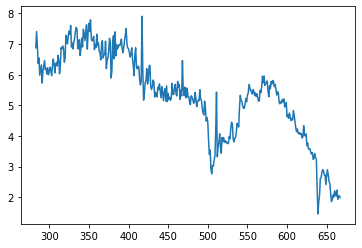

In [315]:
df['Domestic Autos'].plot()

Preprocessing, separating into train and test.

In [184]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [185]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [291]:
X2, y2 = df_to_X_y2(df, 4)
X2.shape, y2.shape

((381, 4, 6), (381,))

Since COVID and the months after are essentially a 'shock' to the model, we will train and validate data before COVID and then test it on the last 11 months before COVID.

In [292]:
X2_train, y2_train = X2[:250], y2[:250]
X2_val, y2_val = X2[250:340], y2[250:340]
X2_test, y2_test = X2[340:351], y2[340:351]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((250, 4, 6), (250,), (90, 4, 6), (90,), (11, 4, 6), (11,))

In [293]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [294]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
#y2_train = (y2_train - np.mean(y2_train)) / np.std(y2_train) 
#y2_val = (y2_val - np.mean(y2_val)) / np.std(y2_val)
#y2_test = (y2_test - np.mean(y2_test)) / np.std(y2_test)

array([[[-1.65970969,  9.477     ,  1.176     ,  2.843     ,
          0.505     ,  2.263     ],
        [-1.60459677,  8.852     ,  1.173     ,  2.651     ,
          0.522     ,  2.145     ],
        [-1.9396483 ,  9.126     ,  1.129     ,  2.735     ,
          0.51      ,  2.223     ],
        [-1.86266518,  9.618     ,  1.15      ,  2.592     ,
          0.524     ,  2.443     ]],

       [[-1.60459677,  8.852     ,  1.173     ,  2.651     ,
          0.522     ,  2.145     ],
        [-1.9396483 ,  9.126     ,  1.129     ,  2.735     ,
          0.51      ,  2.223     ],
        [-1.86266518,  9.618     ,  1.15      ,  2.592     ,
          0.524     ,  2.443     ],
        [-2.03062835,  9.27      ,  1.179     ,  2.398     ,
          0.57      ,  2.694     ]],

       [[-1.9396483 ,  9.126     ,  1.129     ,  2.735     ,
          0.51      ,  2.223     ],
        [-1.86266518,  9.618     ,  1.15      ,  2.592     ,
          0.524     ,  2.443     ],
        [-2.03062835,  9.2

# Building the models

With each model, the goal is to minimize the mean squared error represented as the validation loss (val_loss). We then plot the model's predictions on the test set (11 months before COVID) vs. the actual values. The hyperparameters that are adjusted to each model are the activation function, the number of layers, and the learning rate.

1-Layer LSTM Model, relu activation

In [301]:
model4 = Sequential()
model4.add(InputLayer((4, 6)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_99 (LSTM)              (None, 64)                18176     
                                                                 
 dense_122 (Dense)           (None, 8)                 520       
                                                                 
 dense_123 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [302]:
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=500)#, callbacks=[cp4])

Epoch 1/500
8/8 [==============================] - 5s 97ms/step - loss: 14.2559 - root_mean_squared_error: 3.7757 - val_loss: 5.7159 - val_root_mean_squared_error: 2.3908
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 2.6930 - root_mean_squared_error: 1.6410 - val_loss: 0.9040 - val_root_mean_squared_error: 0.9508
Epoch 3/500
8/8 [==============================] - 0s 13ms/step - loss: 1.3589 - root_mean_squared_error: 1.1657 - val_loss: 0.4026 - val_root_mean_squared_error: 0.6345
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 1.0118 - root_mean_squared_error: 1.0059 - val_loss: 1.4811 - val_root_mean_squared_error: 1.2170
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 0.7402 - root_mean_squared_error: 0.8603 - val_loss: 0.4238 - val_root_mean_squared_error: 0.6510
Epoch 6/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3890 - root_mean_squared_error: 0.6237 - val_loss: 0.2700 - val_root_mean_s

(    Predictions  Actuals
 0      5.347132    3.581
 1      5.366592    3.567
 2      5.377026    3.584
 3      5.435882    3.448
 4      5.361793    3.410
 5      5.264599    3.459
 6      5.322139    3.238
 7      5.180279    3.283
 8      5.270594    3.431
 9      5.309714    3.292
 10     5.279843    3.227, 3.655163760478845)

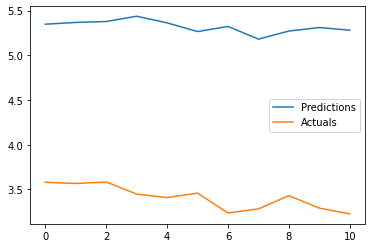

In [303]:
plot_predictions1(model4, X2_test, y2_test)

1-Layer LSTM Model with tanh activation

In [316]:
model4 = Sequential()
model4.add(InputLayer((4, 6)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_103 (LSTM)             (None, 64)                18176     
                                                                 
 dense_128 (Dense)           (None, 8)                 520       
                                                                 
 dense_129 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [317]:
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=500)#, callbacks=[cp4])

Epoch 1/500
8/8 [==============================] - 4s 120ms/step - loss: 14.2418 - root_mean_squared_error: 3.7738 - val_loss: 2.8148 - val_root_mean_squared_error: 1.6778
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 5.9364 - root_mean_squared_error: 2.4365 - val_loss: 1.1679 - val_root_mean_squared_error: 1.0807
Epoch 3/500
8/8 [==============================] - 0s 17ms/step - loss: 3.5826 - root_mean_squared_error: 1.8928 - val_loss: 0.4222 - val_root_mean_squared_error: 0.6497
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 2.1521 - root_mean_squared_error: 1.4670 - val_loss: 0.4054 - val_root_mean_squared_error: 0.6367
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 1.5372 - root_mean_squared_error: 1.2399 - val_loss: 0.7522 - val_root_mean_squared_error: 0.8673
Epoch 6/500
8/8 [==============================] - 0s 12ms/step - loss: 1.3639 - root_mean_squared_error: 1.1678 - val_loss: 1.1234 - val_root_mean_

2-Layer LSTM Model, tanh activation

In [318]:
model6 = Sequential()
model6.add(InputLayer((4, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 4, 32)             4992      
                                                                 
 lstm_105 (LSTM)             (None, 64)                24832     
                                                                 
 dense_130 (Dense)           (None, 8)                 520       
                                                                 
 dense_131 (Dense)           (None, 1)                 9         
                                                                 
Total params: 30,353
Trainable params: 30,353
Non-trainable params: 0
_________________________________________________________________


In [319]:
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model6.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=500)#, callbacks=[cp6])

Epoch 1/500
8/8 [==============================] - 6s 180ms/step - loss: 29.9980 - root_mean_squared_error: 5.4770 - val_loss: 15.5885 - val_root_mean_squared_error: 3.9482
Epoch 2/500
8/8 [==============================] - 0s 16ms/step - loss: 20.5991 - root_mean_squared_error: 4.5386 - val_loss: 8.8286 - val_root_mean_squared_error: 2.9713
Epoch 3/500
8/8 [==============================] - 0s 18ms/step - loss: 13.3337 - root_mean_squared_error: 3.6515 - val_loss: 5.2273 - val_root_mean_squared_error: 2.2863
Epoch 4/500
8/8 [==============================] - 0s 18ms/step - loss: 9.9540 - root_mean_squared_error: 3.1550 - val_loss: 4.0719 - val_root_mean_squared_error: 2.0179
Epoch 5/500
8/8 [==============================] - 0s 19ms/step - loss: 8.8218 - root_mean_squared_error: 2.9701 - val_loss: 3.6210 - val_root_mean_squared_error: 1.9029
Epoch 6/500
8/8 [==============================] - 0s 17ms/step - loss: 8.2461 - root_mean_squared_error: 2.8716 - val_loss: 3.3104 - val_root_me

1-Layer GRU Model, relu activation

In [298]:
model4 = Sequential()
model4.add(InputLayer((4, 6)))
model4.add(GRU(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                13824     
                                                                 
 dense_120 (Dense)           (None, 8)                 520       
                                                                 
 dense_121 (Dense)           (None, 1)                 9         
                                                                 
Total params: 14,353
Trainable params: 14,353
Non-trainable params: 0
_________________________________________________________________


In [299]:
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=500)#, callbacks=[cp4])

Epoch 1/500
8/8 [==============================] - 4s 98ms/step - loss: 40.6595 - root_mean_squared_error: 6.3765 - val_loss: 19.0848 - val_root_mean_squared_error: 4.3686
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 22.4465 - root_mean_squared_error: 4.7378 - val_loss: 9.0492 - val_root_mean_squared_error: 3.0082
Epoch 3/500
8/8 [==============================] - 0s 12ms/step - loss: 13.8995 - root_mean_squared_error: 3.7282 - val_loss: 3.5602 - val_root_mean_squared_error: 1.8869
Epoch 4/500
8/8 [==============================] - 0s 12ms/step - loss: 7.1446 - root_mean_squared_error: 2.6729 - val_loss: 0.6479 - val_root_mean_squared_error: 0.8049
Epoch 5/500
8/8 [==============================] - 0s 11ms/step - loss: 2.8778 - root_mean_squared_error: 1.6964 - val_loss: 0.4715 - val_root_mean_squared_error: 0.6867
Epoch 6/500
8/8 [==============================] - 0s 11ms/step - loss: 1.4131 - root_mean_squared_error: 1.1888 - val_loss: 1.6505 - val_root_mea

(    Predictions  Actuals
 0      4.369994    3.581
 1      4.357705    3.567
 2      4.367465    3.584
 3      4.343698    3.448
 4      4.262586    3.410
 5      4.214487    3.459
 6      4.218523    3.238
 7      4.075284    3.283
 8      4.095912    3.431
 9      4.151893    3.292
 10     4.074737    3.227, 0.6773458123123987)

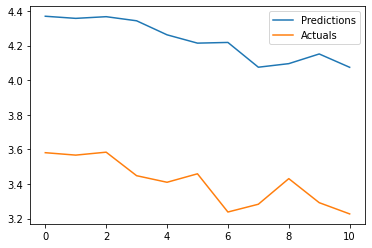

In [300]:
plot_predictions1(model4, X2_test, y2_test)

# The Best Model (Min Validation Loss: 0.06)

2-Layer LSTM, relu activation

In [295]:
model6 = Sequential()
model6.add(InputLayer((4, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_97 (LSTM)              (None, 4, 32)             4992      
                                                                 
 lstm_98 (LSTM)              (None, 64)                24832     
                                                                 
 dense_118 (Dense)           (None, 8)                 520       
                                                                 
 dense_119 (Dense)           (None, 1)                 9         
                                                                 
Total params: 30,353
Trainable params: 30,353
Non-trainable params: 0
_________________________________________________________________


In [296]:
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model6.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=500)#, callbacks=[cp6])

Epoch 1/500
8/8 [==============================] - 5s 160ms/step - loss: 34.3018 - root_mean_squared_error: 5.8568 - val_loss: 21.6366 - val_root_mean_squared_error: 4.6515
Epoch 2/500
8/8 [==============================] - 0s 18ms/step - loss: 28.8607 - root_mean_squared_error: 5.3722 - val_loss: 15.0107 - val_root_mean_squared_error: 3.8744
Epoch 3/500
8/8 [==============================] - 0s 17ms/step - loss: 19.6110 - root_mean_squared_error: 4.4284 - val_loss: 5.9470 - val_root_mean_squared_error: 2.4387
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 8.2937 - root_mean_squared_error: 2.8799 - val_loss: 0.4515 - val_root_mean_squared_error: 0.6720
Epoch 5/500
8/8 [==============================] - 0s 21ms/step - loss: 2.0947 - root_mean_squared_error: 1.4473 - val_loss: 1.9167 - val_root_mean_squared_error: 1.3845
Epoch 6/500
8/8 [==============================] - 0s 18ms/step - loss: 1.6530 - root_mean_squared_error: 1.2857 - val_loss: 3.0470 - val_root_m

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  plt.legend(['Predictions', 'Actuals'])
  return df, mse(y, predictions)

(    Predictions  Actuals
 0      4.264634    3.581
 1      4.204017    3.567
 2      4.249629    3.584
 3      4.265008    3.448
 4      4.223935    3.410
 5      4.206027    3.459
 6      4.201736    3.238
 7      4.053824    3.283
 8      4.099334    3.431
 9      4.073951    3.292
 10     4.019612    3.227, 0.5830507520675929)

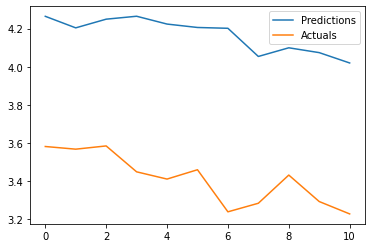

In [297]:
plot_predictions1(model6, X2_test, y2_test)

In conclusion, using the 2-Layer LSTM Model with ReLU activation, we minimize our validation error at 0.06. However, when plotting the predictions vs. the test data, we notice a significant gap between the predictions and the actual values (MSE = 0.58).